$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
$$

# Part 3: Summary Questions
<a id=part2></a>

This section contains summary questions about various topics from the course material.

You can add your answers in new cells below the questions.

**Notes**

- Clearly mark where your answer begins, e.g. write "**Answer:**" in the beginning of your cell.
- Provide a full explanation, even if the question doesn't explicitly state so. We will reduce points for partial explanations!
- This notebook should be runnable from start to end without any errors.

### CNNs

1. Explain the meaning of the term "receptive field" in the context of CNNs.

**Answer:**
A receptive field is the area in the input space that a point in the target space "Sees", or taking into account in the kernel calculation.
It is defined by a center and a size. Naturally, a point in the target space cannot take into account data that is not in its receptive field. <Br>
A receptive field of a single conv. layer is calculated as: <Br>
$r_{i-1} = s_i \cdot r_i + (k_i - s_i)$,<Br>
Where: <Br>
$r_{i-1}$ - receptive field of layer i-1 <Br>
$s_i$ - Stride at layer i <Br>
$k_i$ - kernel size at layer i-1

2. Explain and elaborate about three different ways to control the rate at which the receptive field grows from layer to layer. Compare them to each other in terms of how they combine input features.

**Answer:** Three ways to increase the receptive field:<Br>
1. **Add conv. layers - make network deeper** - by adding more layers with kernel > 1, each point in the target space sees more ponits in the origin space.
    This option increases the receptive field linearly - each additional layer increases the receptive field size by the kernel size.
    This also typically adds a nonlinear layer (RELU etc.) per layer, making the network more complex.
2. **Add pooling layers with corresponding stride** - RF grows with no. of pooling layers multiplicatively, becasue each pooling layer multiplies the RC by the pooling size. Note that without the stride, pooling layers will not multiply the RF, because neighbouring points will have almost the exact same RF, so pooling them together will not chnage much.   e.g. - adding a pooling layer with kernel 2 and strde 1 will change the RF from x to x+1 in each dimension, because the rest of the points in the origin space will be be the same.
3. **Dilated convolution** - introduce spaces between kernel values, hence while the number of kernel weights is the same, the area covered is multiplied by r (dilation rate). <Br>
    Hence, the RF grows exponentioally with 
    With that said, not all points in the original space are covered by each kernel, it is a sparse sampling of the space per kernel operation.
    

3. Imagine a CNN with three convolutional layers, defined as follows:

In [12]:
import torch
import torch.nn as nn

cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, stride=2, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, dilation=2, padding=3),
    nn.ReLU(),
)

cnn(torch.rand(size=(1, 3, 1024, 1024), dtype=torch.float32)).shape

torch.Size([1, 32, 122, 122])

What is the size (spatial extent) of the receptive field of each "pixel" in the output tensor?

**Answer:** The receptive field after the last layer is 112x112. <Br>
Explanation: for every layer, the output RC is provided by: $r = \sum_{i=1}^{L} (d_i (k_i - 1) \cdot \Pi_{j=0}^{j-1} s_j ) +1$ <Br>
    
Please see the changes per layer in the following table, RELU layers ommitted because they have no impact on RC.<Br>
first layer is calculated explicitly in the table as an example
    

    
| Layer | k | s | d | RF Before | RF After | comments |
| --- | --- | --- | --- | --- | --- | --- |
| Conv2d | 3 | 1 | 1 | 1 | 3 | $r = 1 \cdot (3-1) \cdot 1) + 1$ = 3 |
| MaxPool2d | 2 | 2 | 1 | 3 | 4 | +1 overall, because the stride in the last conv. layer is 1 |
| Conv2d | 5 | 2 | 1 | 4 | 12 | by the equation above |
| MaxPool2d | 2 | 2 | 1 | 12 | 16 | by the equation above |
| Conv2d | 7 | 1 | 2 | 16 | 112 | by the equation above |


4. You have trained a CNN, where each layer $l$ is represented by the mapping $\vec{y}_l=f_l(\vec{x};\vec{\theta}_l)$, and $f_l(\cdot;\vec{\theta}_l)$ is a convolutional layer (not including the activation function).

  After hearing that residual networks can be made much deeper, you decide to change each layer in your network you used the following residual mapping instead $\vec{y}_l=f_l(\vec{x};\vec{\theta}_l)+\vec{x}$, and re-train.

  However, to your surprise, by visualizing the learned filters $\vec{\theta}_l$ you observe that the original network and the residual network produce completely different filters. Explain the reason for this.

**Answer:** <Br>
This makes sense because the filters are learned parameters and the learned distribution is different.<Br>
In "Regular" CNN the conv. layer tries to learn the original target distribution $H(x)$, hence $x \rightarrow H(x)$. <Br>
In Resnet, since we add $x \cdot I$ to the output, the conv. layer tries to learn $x \rightarrow H(x) - x$. <Br>
This is also where the name comes from:  $Residual = R(x) := H(x)-x$<Br>
Since the learned distribution is totally different, the filters (learned params) are also different.





### Dropout

1. Consider the following neural network:

In [2]:
import torch.nn as nn

p1, p2 = 0.1, 0.2
nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Dropout(p=p1),
    nn.Dropout(p=p2),
)

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Dropout(p=0.2, inplace=False)
)

If we want to replace the two consecutive dropout layers with a single one defined as follows:
```python
nn.Dropout(p=q)
```
what would the value of `q` need to be? Write an expression for `q` in terms of `p1` and `p2`.

**Answer:** <Br>
$q = p_1 + p_2 - p_1 \cdot p_2 = 0.28$ <Br>
Explanation: <Br>
Each connection can be dropped (Zeroed) :<Br>
- Exclusively by the first dropout with probability $p1 - p_1 \cdot p_2$
- Exclusively by the second dropout with probability $p2 - p_1 \cdot p_2$
- By both (same result as being dropped once) with probability $p_1 \cdot p_2$<Br>
<Br>
So, to cancel duplication, we need to sum the three and get the union probability: $q = p_1 + p_2 - p_1 \cdot p_2 = 0.28$ <Br>




    


2. **True or false**: dropout must be placed only after the activation function.

**Answer:**
False - It is the general practice to place the dropout layer after the activation layer, and based on the selection activation function this could lead to different results (e.g. - with Sigmoid). <Br>
With RELU the results are identical regardless of the order of these layers (RELU of 0 is 0) so it could be more computationally efficient to place the dropouts before the RELU.
    



3. After applying dropout with a drop-probability of $p$, the activations are scaled by $1/(1-p)$. Prove that this scaling is required in order to maintain the value of each activation unchanged in expectation.

**Answer:**<Br>
Let $\vec{x}$ be the tensor of values after the activation function, and <Br>
Let the expected value of $x_i$ be equal to some value $a$, so $\forall i: E(x_i) = a$ <Br>
so if we dropout (Zero) elements in $\vec x$ with probability $p$, so the new expectation is:<Br>
$\forall i: E(x_i) = (1-p)a$ <Br>
In order to set it back to $a$, we multiply by $\dfrac{1}{1-p}$, so that:<br>
$E(x_i) = (1-p) \cdot \dfrac{1}{1-p} \cdot a = a$



### Losses and Activation functions

1. You're training a an image classifier that, given an image, needs to classify it as either a dog (output 0) or a hotdog (output 1). Would you train this model with an L2 loss? if so, why? if not, demonstrate with a numerical example. What would you use instead?

**Answer:** For a binary classifier I would not use an L2 loss because it is more suitable for values in the range $[-\infty, \infty]$, while the error values of classifiers are in the probability range, i.e. $[0, 1]$.
Instead I would use binary cross-entropy loss, which is designed for probabilities in the range of $[0, 1]$.<Br>

Generally speaking, we want loss funcitons to "Punish" big mistakes strongly and small mistakes weakly, with significantly different gradient values between these cases.    As can be seen in the plot below, in the relevant error range of $[0, 1]$:
- L2 loss behaves almost linearly, with loss values in $[0, 1]$ - small loss range, no "growing punsihment" for large error (almost const. gradient)
- Binary Cross-entropy (log loss) behaves much more as described above - loss range $[0, \infty]$, gradient growing with the loss 



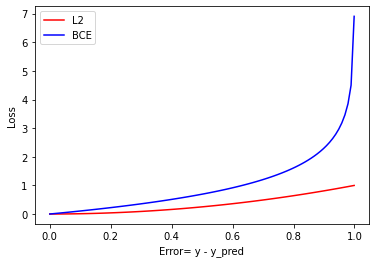

In [30]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0, 1-1e-3, 100)
se = (0-x)**2
bce = -np.log(1-x)

fig = plt.figure()
plt.plot(x, se, color='r', label='L2')
plt.plot(x, bce, color='b', label='BCE')
plt.xlabel('Error= y - y_pred')
plt.ylabel('Loss')
plt.legend()

2. After months of research into the origins of climate change, you observe the following result:

<center><img src="https://sparrowism.soc.srcf.net/home/piratesarecool4.gif" /></center>

You decide to train a cutting-edge deep neural network regression model, that will predict the global temperature based on the population of pirates in `N` locations around the globe.
You define your model as follows:

In [24]:
import torch.nn as nn

N = 42  # number of known global pirate hot spots
H = 128
mlpirate = nn.Sequential(
    nn.Linear(in_features=N, out_features=H),
    nn.Sigmoid(),
    *[
        nn.Linear(in_features=H, out_features=H), nn.Sigmoid(),
    ]*24,
    nn.Linear(in_features=H, out_features=1),
)

While training your model you notice that the loss reaches a plateau after only a few iterations.
It seems that your model is no longer training.
What is the most likely cause?

**Answer:** The most likely cause is vanishing gradients.
Sigmoid function takes very wide range of input and squashes it to a very small output rane of $[0,1]$, hence for values far from zero the gradient is very close to zero.   
In a deep network, with many such layers stacked, the training tends to get stuck in a stable state where the parameter values are extreme (Far from zero), the gradient is numerically zero, and so the optimizer gets stuck in place and the loss does not improve.

3. Referring to question 2 above: A friend suggests that if you replace the `sigmoid` activations with `tanh`, it will solve your problem. Is he correct? Explain why or why not.

**Answer:** 
No it will not solve the problem.    
Tanh function is veri similar to sigmoid in the attributes mentioned above, only the target range is $[-1, 1]$ instead of $[0, 1]$.  
The same problem will occure.

4. Regarding the ReLU activation, state whether the following sentences are **true or false** and explain:<br>
 A. In a model using exclusively ReLU activations, there can be no vanishing gradients.<br>
 B. The gradient of ReLU is linear with its input when the input is positive.<br>
 C. ReLU can cause "dead" neurons, i.e. activations that remain at a constant value of zero.<br>


**Answers:** <Br>
A. **False** - Relu can cause vanishing gradients as well in case of negative values, because when $x \leq 0$ the gradient is 0<br>
B. **False** - The gradient of RELU is constant for any x>0 - and equals to the relu slope<br>
C. **True** - for $x \leq 0$ the ReLU returns zero.   If the weights are such that any actual input that reach the activation is negative (e.g. the neuron gets only small values and there is a huge negative bias weight), the neuron will appear dead.

### Optimization

1. Explain the difference between: stochastic gradient descent (SGD), mini-batch SGD and regular gradient descent (GD).

**Answer:**
All three gradient descent methods go through the same steps iteratively: forward pass, calculate loss, backward pass (Calculate grads), optimizer step (Update parameters).  The main differences:
- SGD - run the entire cycle above for each and every sample separately.   It converges much faster than regular GD, and tends to be much more "Jumpy", because the optimizer takes longer and noisier path to the optimum.
- Mini-batch SGD - run the entire cycle above per mini batch, which is a subset of the training data (More than one sample, but not all of it).   It generally converges faster than regular GD (With reasonable number of samples per batch) and is less jumpy than the SGD, because the gradients are averaged over several samples.
- Regular GD - run the above cycle per the entire train dataset every time.    Slow, because every optiizer step requires going through the entire training set, much smoother optimizer path than SGD.



2. Regarding SGD and GD:
  1. Provide at least two reasons for why SGD is used more often in practice compared to GD.
  2. In what cases can GD not be used at all?

**Answer:**

Two reasons SGD is used more often than GD:
- Regular GD requires to go over all samples to calculate the gradients, which requires much memory and is sometimes unrealistic
- SGD Converges much faster because every sample leads to an optimization step, so even of the path is longer and noisier, it happens faster in terms of runtime. 

3. You have trained a deep resnet to obtain SoTA results on ImageNet.
While training using mini-batch SGD with a batch size of $B$, you noticed that your model converged to a loss value of $l_0$ within $n$ iterations (batches across all epochs) on average.
Thanks to your amazing results, you secure funding for a new high-powered server with GPUs containing twice the amount of RAM.
You're now considering to increase the mini-batch size from $B$ to $2B$.
Would you expect the number of of iterations required to converge to $l_0$ to decrease or increase when using the new batch size? explain in detail.

--------------------------------
***I am here***
--------------------------------
--------------------------------


4. For each of the following statements, state whether they're **true or false** and explain why.
  1. When training a neural network with SGD, every epoch we perform an optimization step for each sample in our dataset.
  1. Gradients obtained with SGD have less variance and lead to quicker convergence compared to GD.
  1. SGD is less likely to get stuck in local minima, compared to GD.
  1. Training  with SGD requires more memory than with GD.
  1. Assuming appropriate learning rates, SGD is guaranteed to converge to a local minimum, while GD is guaranteed to converge to the global minimum.
  1. Given a loss surface with a narrow ravine (high curvature in one direction): SGD with momentum will converge more quickly than Newton's method which doesn't have momentum.

5. **Bonus** (we didn't discuss this at class):  We can use bi-level optimization in the context of deep learning, by embedding an optimization problem as a layer in the network.
  **True or false**: In order to train such a network, the inner optimization problem must be solved with a descent based method (such as SGD, LBFGS, etc).
  Provide a mathematical justification for your answer.

6. You have trained a neural network, where each layer $l$ is represented by the mapping $\vec{y}_l=f_l(\vec{x};\vec{\theta}_l)$ for some arbitrary parametrized functions $f_l(\cdot;\vec{\theta}_l)$.
  Unfortunately while trying to break the record for the world's deepest network, you discover that you are unable to train your network with more than $L$ layers.
  1. Explain the concepts of "vanishing gradients", and "exploding gradients".
  2. How can each of these problems be caused by increased depth?
  3. Provide a numerical example demonstrating each.
  4. Assuming your problem is either of these, how can you tell which of them it is without looking at the gradient tensor(s)?

### Backpropagation

1. You wish to train the following 2-layer MLP for a binary classification task:
  $$
  \hat{y}^{(i)} =\mat{W}_2~ \varphi(\mat{W}_1 \vec{x}^{(i)}+ \vec{b}_1) + \vec{b}_2
  $$
  Your wish to minimize the in-sample loss function is defined as
  $$
  L_{\mathcal{S}} = \frac{1}{N}\sum_{i=1}^{N}\ell(y^{(i)},\hat{y}^{(i)}) + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
  $$
  Where the pointwise loss is binary cross-entropy:
  $$
  \ell(y, \hat{y}) =  - y \log(\hat{y}) - (1-y) \log(1-\hat{y})
  $$
  
  Write an analytic expression for the derivative of the final loss $L_{\mathcal{S}}$ w.r.t. each of the following tensors: $\mat{W}_1$, $\mat{W}_2$, $\mat{b}_1$, $\mat{b}_2$, $\mat{x}$.

2. The derivative of a function $f(\vec{x})$ at a point $\vec{x}_0$ is
  $$
  f'(\vec{x}_0)=\lim_{\Delta\vec{x}\to 0} \frac{f(\vec{x}_0+\Delta\vec{x})-f(\vec{x}_0)}{\Delta\vec{x}}
  $$
  
  1. Explain how this formula can be used in order to compute gradients of neural network parameters numerically, without automatic differentiation (AD).
  
  2. What are the drawbacks of this approach? List at least two drawbacks compared to AD.

3. Given the following code snippet:
  1. Write a short snippet that implements that calculates gradient of `loss` w.r.t. `W` and `b` using the approach of numerical gradients from the previous question.
  2. Calculate the same derivatives with autograd.
  3. Show, by calling `torch.allclose()` that your numerical gradient is close to autograd's gradient.

In [4]:
import torch

N, d = 100, 5
dtype = torch.float64
X = torch.rand(N, d, dtype=dtype)
W, b = torch.rand(d, d, requires_grad=True, dtype=dtype), torch.rand(d, requires_grad=True, dtype=dtype)

def foo(W, b):
    return torch.mean(X @ W + b)

loss = foo(W, b)
print(f"{loss=}")

# TODO: Calculate gradients numerically for W and b
# grad_W =...
# grad_b =...

# TODO: Compare with autograd using torch.allclose()
# autograd_W = ...
# autograd_b = ...
# assert torch.allclose(grad_W, autograd_W)
# assert torch.allclose(grad_b, autograd_b)

loss=tensor(1.9033, dtype=torch.float64, grad_fn=<MeanBackward0>)


### Sequence models

1. Regarding word embeddings:
  1. Explain this term and why it's used in the context of a language model.
  1. Can a language model like the sentiment analysis example from the tutorials be trained without an embedding (i.e. trained directly on sequences of tokens)? If yes, what would be the consequence for the trained model? if no, why not?

2. Considering the following snippet, explain:
  1. What does `Y` contain? why this output shape?
  2. **Bonus**: How you would implement `nn.Embedding` yourself using only torch tensors. 

In [5]:
import torch.nn as nn

X = torch.randint(low=0, high=42, size=(5, 6, 7, 8))
embedding = nn.Embedding(num_embeddings=42, embedding_dim=42000)
Y = embedding(X)
print(f"{Y.shape=}")

Y.shape=torch.Size([5, 6, 7, 8, 42000])


3. Regarding truncated backpropagation through time (TBPTT) with a sequence length of S: State whether the following sentences are **true or false**, and explain.
  1. TBPTT uses a modified version of the backpropagation algorithm.
  2. To implement TBPTT we only need to limit the length of the sequence provided to the model to length S.
  3. TBPTT allows the model to learn relations between input that are at most S timesteps apart.

### Attention

1. In tutorial 5 we learned how to use attention to perform alignment between a source and target sequence in machine translation.
  1. Explain qualitatively what the addition of the attention mechanism between the encoder and decoder does to the hidden states that the encoder and decoder each learn to generate (for their language). How are these hidden states different from the model without attention?
  
  2. After learning that self-attention is gaining popularity thanks to the transformer models, you decide to change the model from the tutorial: instead of the queries being equal to the decoder hidden states, you use self-attention, so that the keys, queries and values are all equal to the encoder's hidden states (with learned projections, like in the tutorial..). What influence do you expect this will have on the learned hidden states?


### Unsupervised learning

1. As we have seen, a variational autoencoder's loss is comprised of a reconstruction term and  a KL-divergence term. While training your VAE, you accidentally forgot to include the KL-divergence term.
What would be the qualitative effect of this on:

  1. Images reconstructed by the model during training ($x\to z \to x'$)?
  1. Images generated by the model ($z \to x'$)?

2. Regarding VAEs, state whether each of the following statements is **true or false**, and explain:
  1. The latent-space distribution generated by the model for a specific input image is $\mathcal{N}(\vec{0},\vec{I})$.
  2. If we feed the same image to the encoder multiple times, then decode each result, we'll get the same reconstruction.
  3. Since the real VAE loss term is intractable, what we actually minimize instead is it's upper bound, in the hope that the bound is tight.

2. Regarding GANs, state whether each of the following statements is **true or false**, and explain:
  1. Ideally, we want the generator's loss to be low, and the discriminator's loss to be high so that it's fooled well by the generator.
  2. It's crucial to backpropagate into the generator when training the discriminator.
  3. To generate a new image, we can sample a latent-space vector from $\mathcal{N}(\vec{0},\vec{I})$.
  4. It can be beneficial for training the generator if the discriminator is trained for a few epochs first, so that it's output isn't arbitrary.
  5. If the generator is generating plausible images and the discriminator reaches a stable state where it has 50% accuracy (for both image types), training the generator more will further improve the generated images.

### Detection and Segmentation 

1. What is the diffrence between IoU and Dice score? what's the diffrance between IoU and mAP?
    shortly explain when would you use what evaluation?

2. regarding of YOLO and mask-r-CNN, witch one is one stage detector? describe the RPN outputs and the YOLO output, adress how the network produce the output and the shapes of each output.